In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector

import numpy as np

We implement a simple quantum calculator. Specifically, we write a Qiskit function, using only Hadamard, X gates, (single-qubit) Z-rotations, CX gates and Toffoli gates, that takes as input a positive integer $d$ and outputs a quantum circuit QCalc on $3d+1$ qubits (plus $d$ ancillas) such that
\begin{align*}
\mathrm{QCalc} \left( |x\rangle_d \ |y\rangle_d \ |z\rangle_1 \ |0\rangle_d \right)& = \begin{cases} 
x\rangle_d \ |y\rangle_d \ |z\rangle_1 \ |x+y\rangle_d & \mbox{if }z=0 \\
x\rangle_d \ |y\rangle_d \ |z\rangle_1 \ |x\cdot y\rangle_d & \mbox{if }z=1
\end{cases}
 \end{align*}
where all arithmetic is modulo $2^d$.

The calculator uses Draper's adder, based on the quantum Fourier transform (QFT) [1] and a QFT multiplier based on controlled quantum adders [2].

*References* <br>
[1] Thomas G. Draper, "Addition on a quantum computer", arXiv preprint quant-ph/0008033. <br>
[2] Lidia Ruiz-Perez and Juan Carlos Garcia-Escartin, "Quantum arithmetic with the quantum Fourier transform", Quantum Information Processing, 2017.

We first implement the QFT. This makes use of controlled $\frac\pi{2^k}$-phase gates and swap gates. Before implementing the QFT, we first implement these controlled phase gates and swap gates using only single-qubit rotation gates, and CX gates.

In [2]:
quantum_register = QuantumRegister(size=2, name="x")
swap_circuit = QuantumCircuit(quantum_register, name="swap")
swap_circuit.cx(quantum_register[0],quantum_register[1])
swap_circuit.cx(quantum_register[1],quantum_register[0])
swap_circuit.cx(quantum_register[0],quantum_register[1])
Swap = swap_circuit.to_gate()

A controlled Z-rotation can be obtained using a combination of Z-rotations and CX gates as below.

If the control qubit is 0: the rotations on the target qubit undo each other. If the control qubit is 1: the X gate rotates around the x-axis in the Bloch sphere; hence conjugating the second rotation on the target flips the direction of the second rotation.

In [3]:
# following function implements this to generate controlled Z-rotation gates
def crz(angle):
    quantum_register = QuantumRegister(size=2, name="x")
    crz_circuit = QuantumCircuit(quantum_register,name="crz")
    crz_circuit.p(angle/2, quantum_register[1])
    crz_circuit.cx(quantum_register[0],quantum_register[1])
    crz_circuit.p(-angle/2, quantum_register[1])
    crz_circuit.cx(quantum_register[0],quantum_register[1])

    return crz_circuit

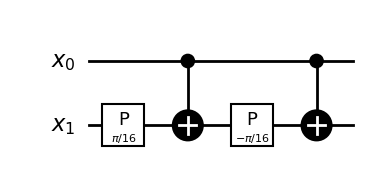

In [4]:
crz(np.pi/8).draw(output="mpl", style="bw")

To create our multiplication, it will also be useful to have a double-controlled version of this gate. This is achieved by replacing the CX gates with Toffoli gates.

In [5]:
# following function implements double-controlled Z-rotation gates, as described in previous markup
def ccrz(angle):
    quantum_register = QuantumRegister(size=3, name="x")
    ccrz_circuit = QuantumCircuit(quantum_register,name="crz")
    ccrz_circuit.p(angle/2, quantum_register[2])
    ccrz_circuit.ccx(quantum_register[0],quantum_register[1],quantum_register[2])
    ccrz_circuit.p(-angle/2, quantum_register[2])
    ccrz_circuit.ccx(quantum_register[0],quantum_register[1],quantum_register[2])

    return ccrz_circuit

We now implement the QFT and inverse QFT. 

In [6]:
# This code is taken from Boot Camp Notebook 2 
# (with substitutions to replace the use of the swap and controlled Z-rotation gates with versions built from elementary gates)

def quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    QFT_circuit = QuantumCircuit(quantum_register, name=f"QFT")

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        #QFT_circuit.swap(q, p)
        QFT_circuit.compose(Swap,qubits=[q,p],inplace=True)


    for i, q in enumerate(quantum_register, start=1):
        QFT_circuit.h(q)
        for j, p in enumerate(quantum_register[i:], start=1):
            #QFT_circuit.cp(np.pi / (1 << j), q, p)
            QFT_circuit.compose(crz(np.pi / (1 << j)), qubits=[q,p], inplace=True)

    return QFT_circuit

def inverse_quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    inverse_QFT_circuit = QuantumCircuit(quantum_register, name=f"IQFT")

    for i, q in enumerate(reversed(quantum_register), start=1):
        for j, p in enumerate(reversed(quantum_register[n + 1 - i:]), start=1):
            #inverse_QFT_circuit.cp(- np.pi / (1 << (i - j)), q, p)
            inverse_QFT_circuit.compose(crz( -np.pi / (1 << (i-j))), qubits=[q,p], inplace=True)
            
        inverse_QFT_circuit.h(q)

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        #inverse_QFT_circuit.swap(q, p)
        inverse_QFT_circuit.compose(Swap,qubits=[q,p],inplace=True)


    return inverse_QFT_circuit

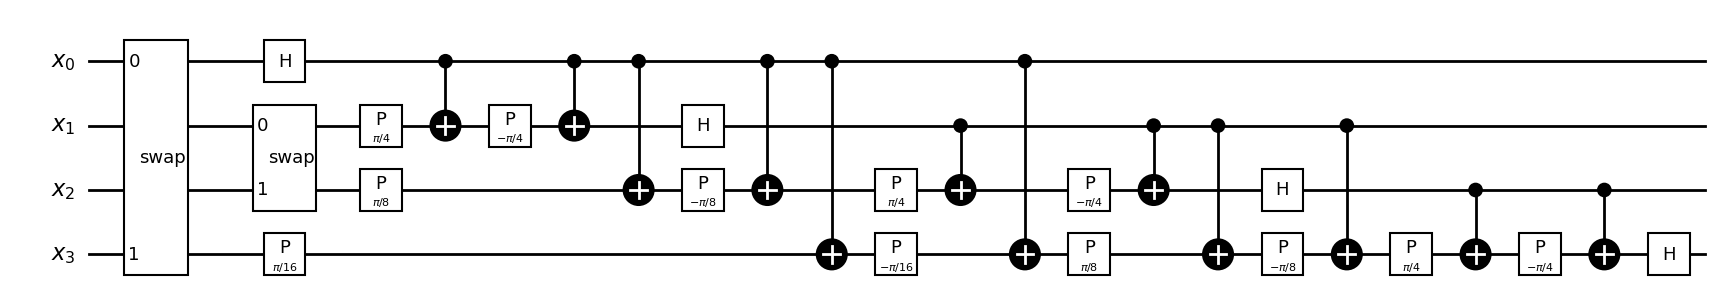

In [18]:
quantum_fourier_transform(4).draw(output="mpl", style="bw")

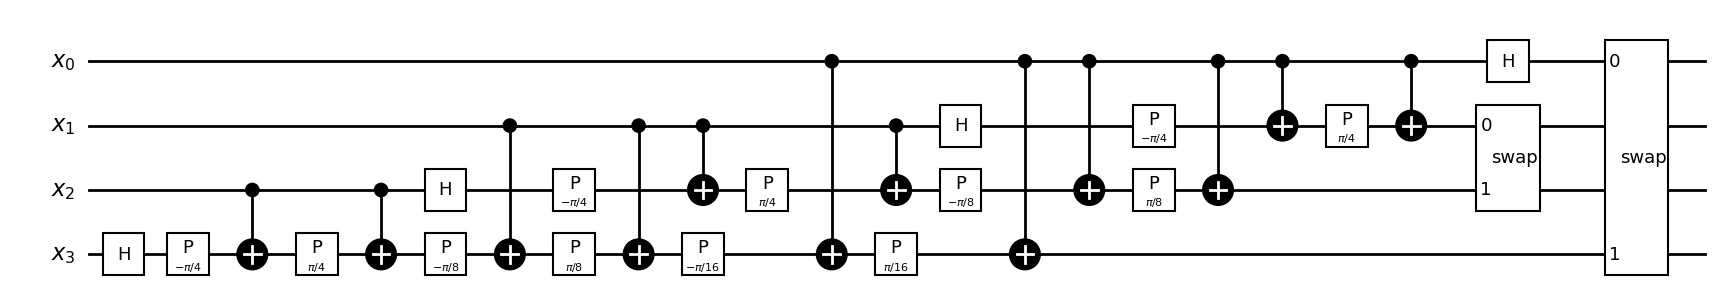

In [19]:
inverse_quantum_fourier_transform(4).draw(output="mpl", style="bw")

We now create quantum adder and multiplier circuits.

To create our final circuit, we will (in fact only) need a controlled version of these circuit, where we use our double-controlled Z-rotation gates instead of controlled Z-rotations.

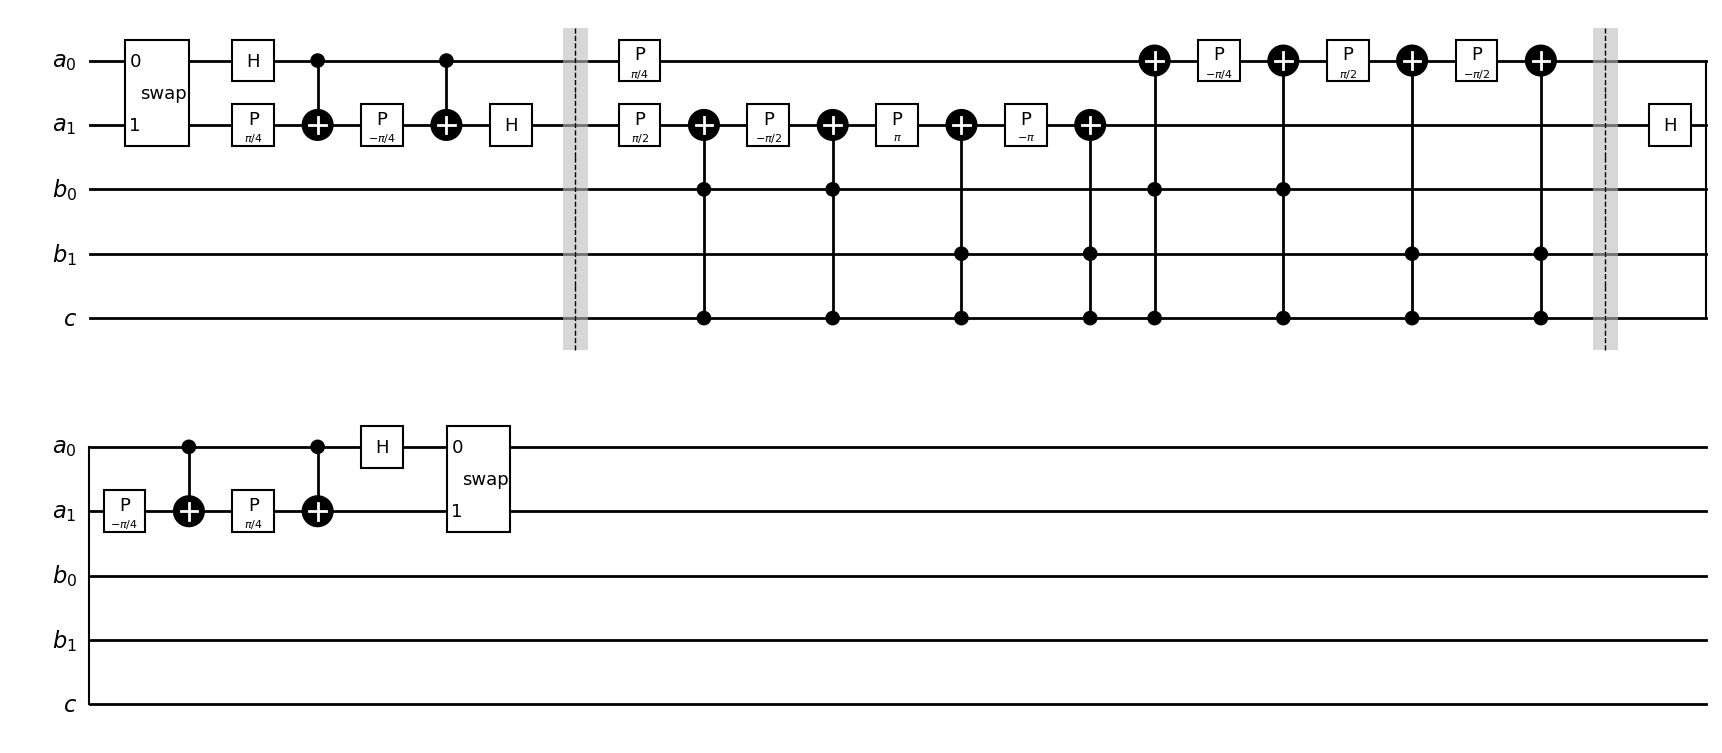

In [7]:
# creates a quantum circuit on 2d+1 qubits 
# given |a> |b> |c>, returns |a+b mod 2^d> |b> |c> if c=1, or |a> |b> |c> if c=0
def c_quantum_adder(d):
    a_register = QuantumRegister(size=d, name="a")
    b_register = QuantumRegister(size=d, name="b")
    c_register = QuantumRegister(size=1, name="c")
    
    quantum_adder_circuit = QuantumCircuit(a_register, b_register, c_register, name=f"{d}-qubit adder")
    
    quantum_adder_circuit.compose(quantum_fourier_transform(d), inplace=True)
    quantum_adder_circuit.barrier()

    # phaser part
    for ida, q in enumerate(reversed(a_register)):
        for idb, r in enumerate(b_register):
            quantum_adder_circuit.compose(ccrz((1 << idb) * np.pi / (1 << ida)), qubits=[2*d,r,q], inplace=True)

    quantum_adder_circuit.barrier()
    quantum_adder_circuit.compose(inverse_quantum_fourier_transform(d), inplace=True)
    
    return quantum_adder_circuit

c_quantum_adder(2).draw(output="mpl", style="bw")

We will also need to use a controlled subtractor circuit. We create this next. This is the same as the adder circuit, except we negate all the phase shifts --- this has the effect of adding $-b$ instead of $b$.

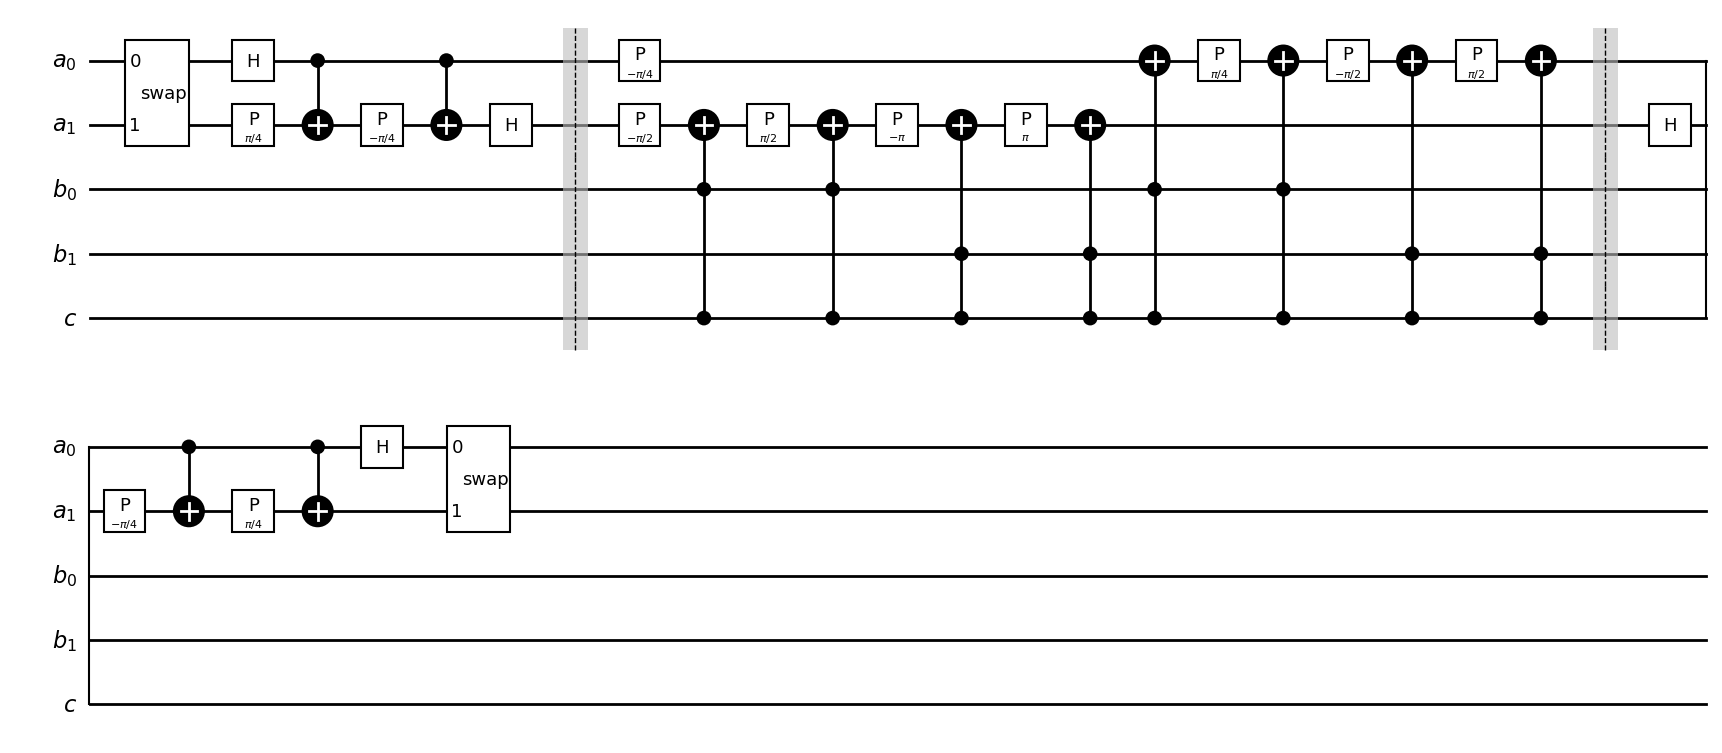

In [8]:
# creates a quantum circuit on 2d+1 qubits
# given |a> |b> |c>, returns |a-b mod 2^d> |b> |c> if c=1, or |a> |b> |c> if c=0
def c_quantum_subtractor(d):
    a_register = QuantumRegister(size=d, name="a")
    b_register = QuantumRegister(size=d, name="b")
    c_register = QuantumRegister(size=1, name="c")
    
    quantum_subtr_circuit = QuantumCircuit(a_register, b_register, c_register, name=f"{d}-qubit subtractor")
    
    quantum_subtr_circuit.compose(quantum_fourier_transform(d), inplace=True)
    quantum_subtr_circuit.barrier()

    # phaser part
    for ida, q in enumerate(reversed(a_register)):
        for idb, r in enumerate(b_register):
            quantum_subtr_circuit.compose(ccrz(-(1 << idb) * np.pi / (1 << ida)), qubits=[2*d,r,q], inplace=True)

    quantum_subtr_circuit.barrier()
    quantum_subtr_circuit.compose(inverse_quantum_fourier_transform(d), inplace=True)
    
    return quantum_subtr_circuit

c_quantum_subtractor(2).draw(output="mpl", style="bw")

Next we create a quantum multiplier circuit. The idea is to write $b = b_0 + b_1 \cdot 2 + \dots + b_d 2^{d-1}$, encode this as the $d$-qubit state $b_0 \cdots b_{d-1}$, and then use these $d$-qubits as control qubits for a sequence of $d$ controlled additions. Each time we are adding (if we are adding at all) twice as much as the previous time: this can be achieved by doubling all of the phase shifts. Note also we do not need to repeat the QFT and inverse QFT between adjacent additions, since these are inverse to each other and would cancel out.

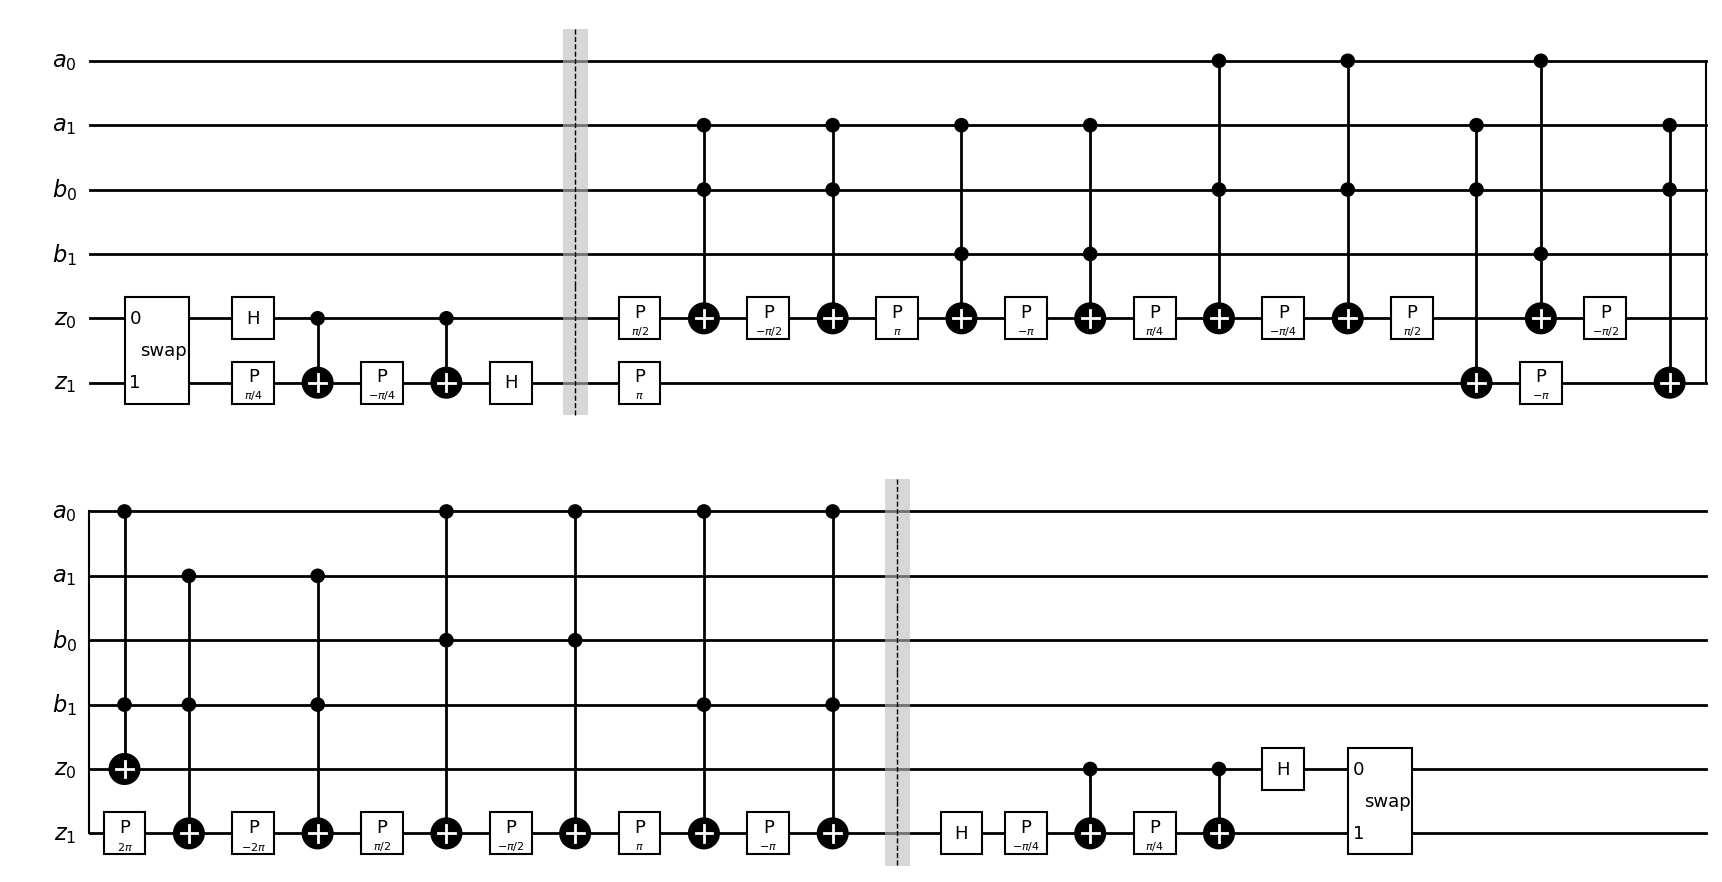

In [9]:
# creates a quantum circuit on 3d qubits
# given |a> |b> |0>, returns |a> |b> |ab mod 2^d> 
# more generally, given |a> |b> |z>, returns |a> |b> |z+ab mod 2^d> 

def quantum_multiplier(d):
    a_register = QuantumRegister(size=d, name="a")
    b_register = QuantumRegister(size=d, name="b")
    result_register = QuantumRegister(size=d, name="z")
    
    quantum_multiplier_circuit = QuantumCircuit(a_register, b_register, result_register, name=f"{d}-qubit multiplier")

    quantum_multiplier_circuit.compose(quantum_fourier_transform(d), qubits=[x+2*d for x in range(d)], inplace=True)
    quantum_multiplier_circuit.barrier()

    for k in range(d): 
        for ida, q in enumerate(reversed(a_register)):
            for idb, r in enumerate(b_register):
                quantum_multiplier_circuit.compose(ccrz((1 << (idb+k)) * np.pi / (1 << ida)), qubits=[r,q,2*d+k], inplace=True)

    quantum_multiplier_circuit.barrier()
    quantum_multiplier_circuit.compose(inverse_quantum_fourier_transform(d), qubits=[x+2*d for x in range(d)], inplace=True)
    
    return quantum_multiplier_circuit

quantum_multiplier(2).draw(output="mpl", style="bw")

We now combine all of this into a single $(3d+1)$-qubit circuit satisfying the specifications. The $3d+1$ qubits may be divided into two "input" registers $|a\rangle_d$ and $|b\rangle_d$, a "control" qubit $|z\rangle_1$ and an "output" register $|r \rangle_d$. In addition, we use an ancilla register of $d$ qubits. 

Below, we keep track of what the circuit does to the starting state $|a\rangle_d \ |b\rangle_d \ |z\rangle_1 \ |0\rangle_d \ |0\rangle_d$. All arithmetic is done modulo $2^d$.

This circuit first uses our multiplier circuit on the input registers, storing the result in the output register. This gives us $|a\rangle_d \ |b\rangle_d \ |z\rangle_1 \ |ab\rangle_d \ |0\rangle_d$.

The circuit then applies an X gate to the control qubit, performs a number of controlled addition / subtraction circuits (described further below), and then another X gate to the control qubit. The controlled circuits only change the state if the control qubit started at 0, i.e. if we started from $|a\rangle_d \ |b\rangle_d \ |0\rangle_1 \ |0\rangle_d \ |0\rangle_d$, then the final state is $|a\rangle_d \ |b\rangle_d \ |z\rangle_1 \ |ab \rangle_d \ |0\rangle_d$.

If we started with $z=1$: we use the controlled addition circuit to add $ab$ from the output register to the ancilla register, giving us $|a\rangle_d \ |b\rangle_d \ |0\rangle_1 \ |ab\rangle_d \ |x+ab\rangle_d$. Then we use controlled addition circuits to add $a$ and $b$ from the input registers to the output register, giving us $|a\rangle_d \ |b\rangle_d \ |0\rangle_1 \ |ab+a+b\rangle_d \ |ab\rangle_d$. Finally, we used the controlled subtraction circuit on the ancilla and output registers to subtract $ab$ from the output register, giving us $|a\rangle_d \ |b\rangle_d \ |0\rangle_1 \ |a+b\rangle_d \ |ab\rangle_d$. Hence, after the final X gate, the final state in this case is $|a\rangle_d \ |b\rangle_d \ |z\rangle_1 \ |a+b\rangle_d \ |ab\rangle_d$.

In [10]:
def QCalc(d):
    a_register = QuantumRegister(size=d, name="a")
    b_register = QuantumRegister(size=d, name="b")
    z_register = QuantumRegister(size=1, name="z")
    res_register = QuantumRegister(size=d, name="result")
    ancilla = AncillaRegister(size=d, name="p")

    calc_circuit = QuantumCircuit(a_register, b_register, z_register, res_register, ancilla, name="QCalc")

    # add ab to result register
    calc_circuit.compose(quantum_multiplier(d), qubits=[x for x in range(2*d)] + [x+2*d+1 for x in range(d)], inplace=True)
    
    # if z=0: add ab to ancilla register, then a+b to result register, then subtract ab from ancilla register
    calc_circuit.x(z_register)
    calc_circuit.compose(c_quantum_adder(d), qubits=[x+3*d+1 for x in range(d)] + [x+2*d+1 for x in range(d)]+[2*d], inplace=True)
    calc_circuit.compose(c_quantum_adder(d), qubits=[x+2*d+1 for x in range(d)] + [x for x in range(d)]+[2*d], inplace=True)
    calc_circuit.compose(c_quantum_adder(d), qubits=[x+2*d+1 for x in range(d)] + [x+d for x in range(d)]+[2*d], inplace=True)
    calc_circuit.compose(c_quantum_subtractor(d), qubits=[x+2*d+1 for x in range(d)] + [x+3*d+1 for x in range(d)]+[2*d], inplace=True)
    calc_circuit.x(z_register)
    
    return calc_circuit

Testing: this works for $d=1$ and $d=2$.

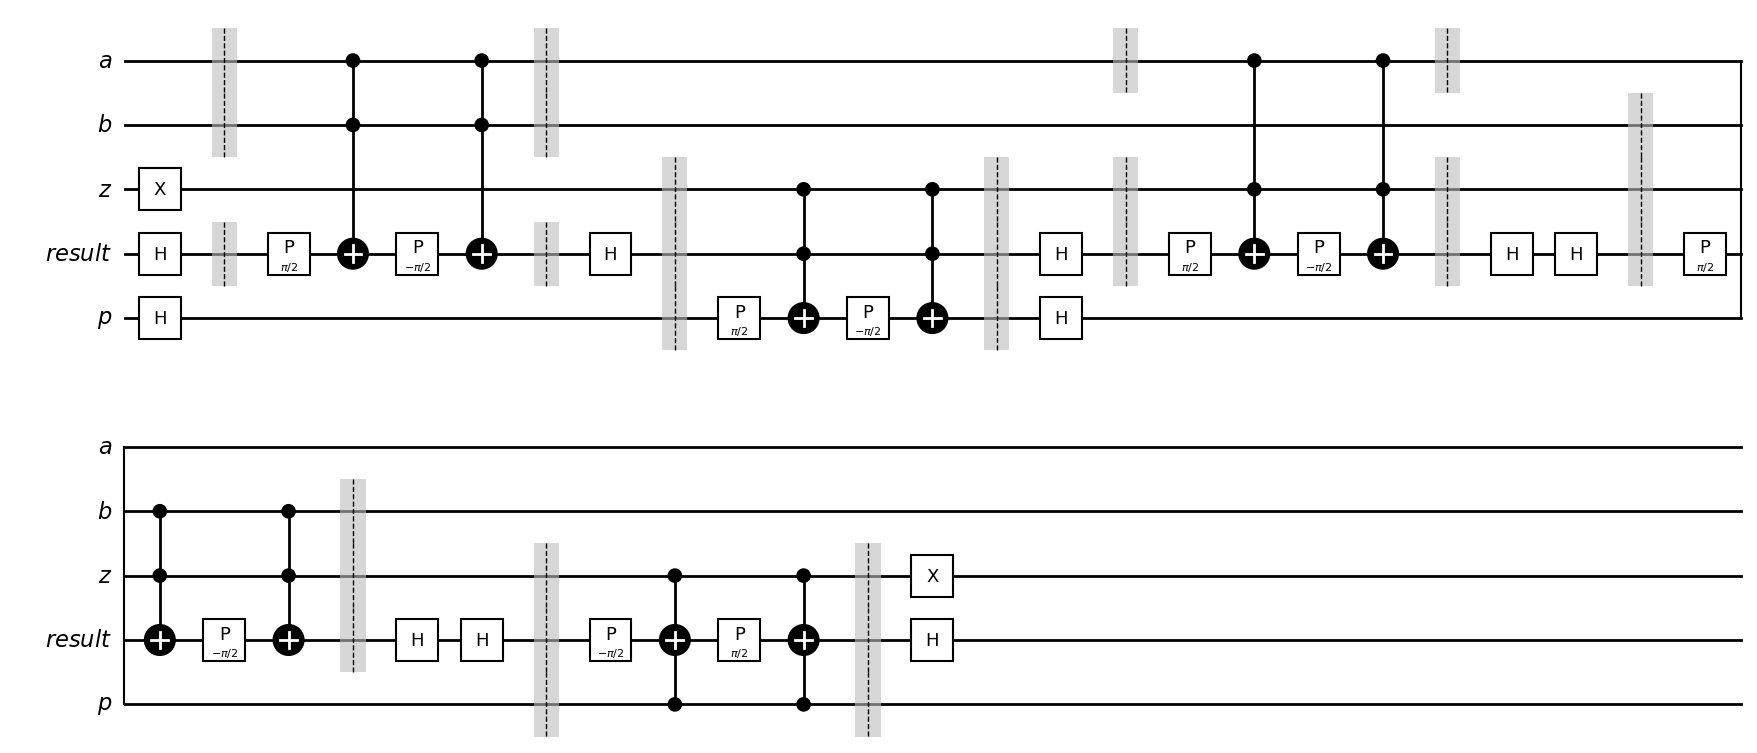

In [11]:
calcone = QCalc(1)
calcone.draw(output="mpl", style="bw")

In [12]:
d=1
total_register = QuantumRegister(size=3*d+1, name="x")
ancilla = AncillaRegister(size=d,name="p")
circuit = QuantumCircuit(total_register, ancilla)
circuit.x(total_register[0])
circuit.x(total_register[1])
#circuit.x(total_register[2])

circuit.compose(QCalc(d), inplace=True)

s = np.round(Statevector(circuit),decimals=1)
p = np.round(Statevector(circuit).probabilities(),decimals=1)
p.nonzero(), len(p)

((array([19], dtype=int64),), 32)

**Asymptotic complexity analysis**

*Ancillas* <br>
The circuit uses $d$ ancillas.

*Gate count and depth* <br>
The circuit uses $O(d^3)$ gates and has $O(d^3)$ depth.

The QFT and inverse QFT use $O(d^2)$ gates and have $O(d)$ depth. The controlled adder / subtractor circuits involve $O(d^2)$ controlled phase shifts (all with the same control qubit), and hence also use $O(d^2)$ gates and have $O(d^2)$ depth. The multiplication circuit involves $O(d^3)$ controlled phase shifts. These do not all with the same control qubit; however, because of constraints on the order in which the phase shifts must happen, they still cannot be arranged to have less than $O(d^3)$ depth.

We can eliminate some computation by reducing the number of times we perform the QFT and inverse QFT. Since this was not the limiting factor in these asymptotics, we have chosen not to do this here in the interest of making the circuit design slightly more transparent. 

**Benchmarking**

In [13]:
import timeit
runs = 100

In [14]:
for d in range(5):
    time_taken = timeit.timeit(stmt="QCalc("+str(d+1)+")", setup="from __main__ import QCalc", number=runs)
    print(f"Average time taken for {runs} runs of QCalc({d+1}): {time_taken/runs:.6f} seconds")

Average time taken for 100 runs of QCalc(1): 0.009951 seconds
Average time taken for 100 runs of QCalc(2): 0.045292 seconds
Average time taken for 100 runs of QCalc(3): 0.081060 seconds
Average time taken for 100 runs of QCalc(4): 0.156697 seconds
Average time taken for 100 runs of QCalc(5): 0.189319 seconds
